In [47]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from shapely.geometry import shape
import numpy as np
import matplotlib.colors as mcolors

In [48]:
# read csv
data = pd.read_csv('merged_data.csv')
epa_data = data[['CensusTract','Year','County','Total Cancer Risk (per million)']]

# remove rows with NaN values
epa_data = epa_data.dropna()
display(epa_data)


,CensusTract,Year,County,Total Cancer Risk (per million)
0,49001000000,2014,Beaver,1.619873
1,49001000000,2014,Beaver,2.656146
2,49001000000,2014,Beaver,11.295854
3,49001000000,2017,Beaver,2.557997
4,49001000000,2017,Beaver,7.832001
...,...,...,...,...
13016,49057211202,2018,Weber,1.980183
13017,49057211202,2018,Weber,9.515471
13018,49057211202,2019,Weber,1.386927
13019,49057211202,2019,Weber,2.700312


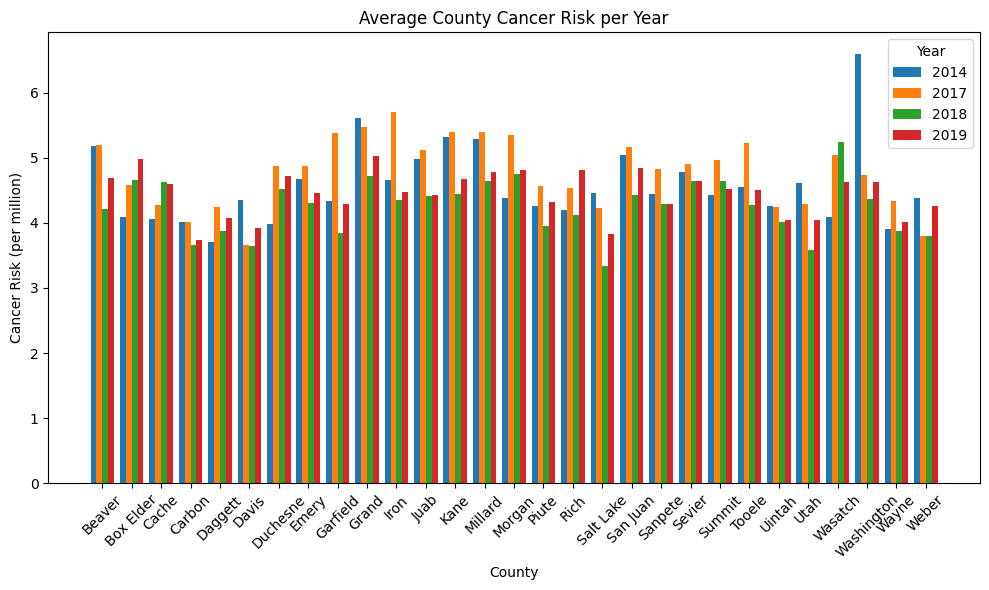

In [49]:
''' “The EPA will generally presume that if the risk to that individual [the Maximum Individual Risk] 
 is no higher than approximately 1 in 10 thousand (100 in 1 million), that risk level is considered acceptable 
 and EPA then considers the other health and risk factors to complete an overall judgment on acceptability.”'''
 # https://www.epa.gov/AirToxScreen/airtoxscreen-frequent-questions
 
#get county average cancer risk
county_avg = epa_data.groupby(['County','Year'])['Total Cancer Risk (per million)'].mean().reset_index()

# Pivot the DataFrame to have years as columns
pivot_df = county_avg.pivot(index='County', columns='Year', values='Total Cancer Risk (per million)')
#display(pivot_df)

# Plotting
bar_width = 0.2
index = np.arange(len(pivot_df.index))
fig, ax = plt.subplots(figsize=(10, 6))
bar_2014 = ax.bar(index - 3 * bar_width / 2, pivot_df[2014], bar_width, label='2014')
bar_2017 = ax.bar(index - bar_width / 2, pivot_df[2017], bar_width, label='2017')
bar_2018 = ax.bar(index + bar_width / 2, pivot_df[2018], bar_width, label='2018')
bar_2019 = ax.bar(index + 3 * bar_width / 2, pivot_df[2019], bar_width, label='2019')

ax.set_title('Average County Cancer Risk per Year')
ax.set_xlabel('County')
ax.set_ylabel('Cancer Risk (per million)')
ax.set_xticks(index)
ax.set_xticklabels(pivot_df.index)
ax.legend(title='Year')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

/tmp/ipykernel_61325/1582703700.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  epa_data2019['CensusTract'] = epa_data2019['CensusTract'].astype(str)


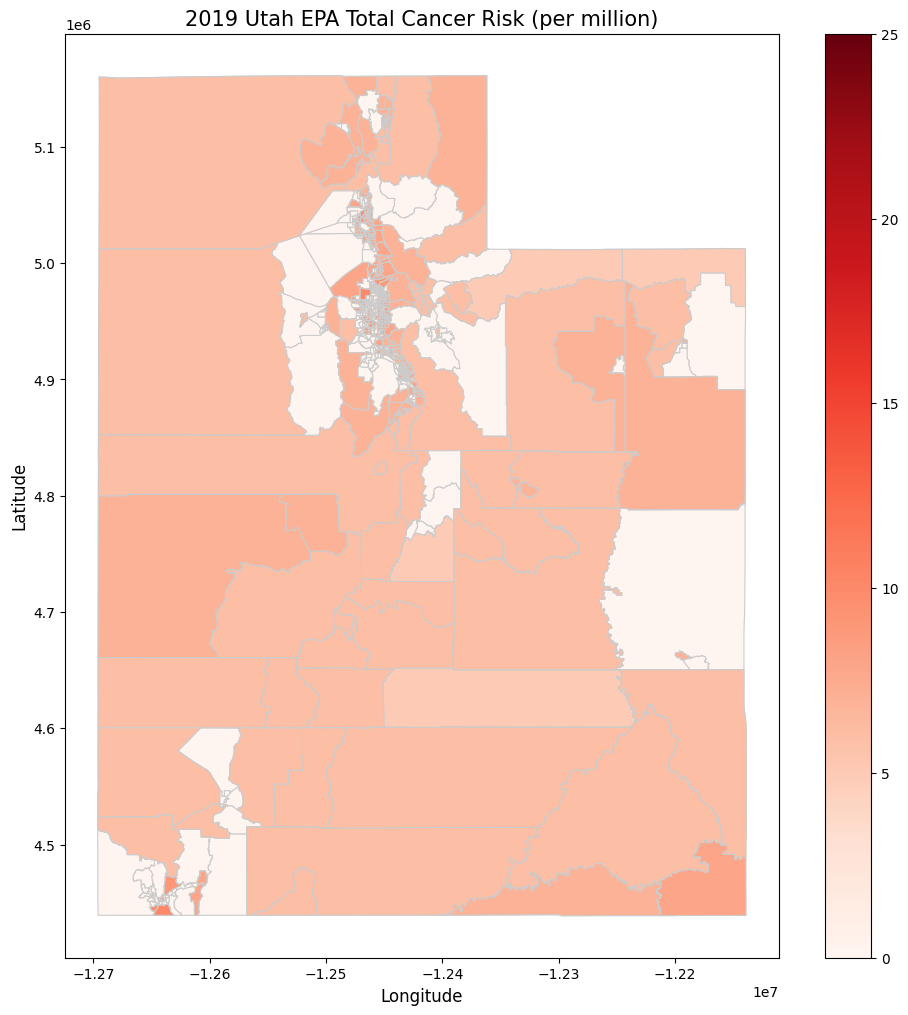

In [50]:
# https://opendata.gis.utah.gov/datasets/utah-census-tracts-2020/about
# 2019 map

# Load the GeoJSON file
geojson = gpd.read_file('CensusTracts2020.geojson')
geojson = geojson.rename(columns={'GEOID20':'CensusTract'})

# Filter 2019 EPA data
epa_data2019 = epa_data[epa_data['Year'] == 2019]

# Ensure the GEOID column is the same type in both dataframes, typically a string
geojson['CensusTract'] = geojson['CensusTract'].astype(str)
epa_data2019['CensusTract'] = epa_data2019['CensusTract'].astype(str)

# Merge the data on the GEOID column
geo_merged = geojson.merge(epa_data2019, on='CensusTract', how='left')

# Remove NaN values
geo_merged = geo_merged.fillna(0)

# Convert Total Cancer Risk to int
geo_merged['Total Cancer Risk (per million)'] = geo_merged['Total Cancer Risk (per million)'].astype(int)

# Normalize cancer risk for color mapping (range from 0 to 25)
norm = mcolors.Normalize(vmin=0, vmax=25)

# Plot using GeoPandas built-in plot function
fig, ax = plt.subplots(figsize=(12, 12))
geo_merged.plot(column='Total Cancer Risk (per million)', cmap='Reds', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True, norm=norm)

ax.set_title('2019 Utah EPA Total Cancer Risk (per million)', fontsize=15)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)

plt.show()